## 1. Project Objective

### Introduction

The aim of this project is to explore and analyze patterns in flu outbreaks. The data used captures all individual laboratory confirmed influenza cases in Australia from 2008-2018. Past data on outbreaks and treatment is very useful in preparation for future flu seasons. Using demographic and location data, it's possible to predict who and where will be most impacted in the future. This information can help direct departments of health on how best to concentrate vaccine awareness and educational funding and resources to combat the virus.

To explore this concept, we will use data obtained from Australia's Department of Health (DOH) at the following url: http://www9.health.gov.au/cda/source/pub_influ.cfm. Each row represents an individual confirmed to have the flu. Additional data beyond type of flu are Australian state of residence (or where diagnosed if non-Australian), age group (in 5-year categories), sex, indigenous status, and year and week of diagnosis (all cases were catalogued weekly on fridays). The data caveats pdf that accompanied the data set mention that indigenous status was not collected for two of the states, and half-way complete for three others.

The target variable for this exercise will be flu type. Our aim will be to predict the type of influenza given all other information about a patient. This will also allow us to define factors that cause the disease. As mentioned above, this could be crucial in setting DOH goals for combatting flu outbreaks and budgeting for said programming. Another possible use is vaccine development; vaccines must be developed and produced in anticipation of the coming season and thus, strong predictions are required to produce optimal vaccines.

### Solution Approach

To tackle my problem I will start out by exploring the data and performing any cleaning or transformations necessary to get yield a usable format. I will follow this up with descriptive statistics and visualizations to understand the shapes of my columns and any trends as well as looking for outliers. Before I begin modeling I will split my data into train and test sets, so I have a final validation set on which I can check my predictions on unseen data. These final accuracy scores are what I will compare to determine best predictive performance.

From here I'll enter into prescriptive statistics, using _mixed models_ and _logistic regression_ to understand the training data. A quick note about mixed modeling and why it's important. 
    
    My specialization for Thinkful's data science bootcamp was "data science for the social sciences." The social  sciences are concerned with change: its causes and effects. One of the best ways to research this is to track  a group of similar data points (students, medical patients, etc.) over time, which is called panel or            longitudinal data. The current standard for modeling panel data is linear mixed effects models, which use a    generalized version of linear regression with additional terms which take into account different dependencies  within data. The "mixed" part of the name refers to the mix of fixed and random effects that make up the model, where fixed effects are typically described as was the researcher is "interested in" and random effects are    what they want to control for.
    
In this project, we are interested in which type of flu a patient has, and we can try controlling for state as a random effect. The package I'll be using is called Pymer4 and is a wrapper package for the R packages Lmer and Lme4.

I will also use logistic regression to explore and better understand the training data. While logistic regression is not the standard for the field, these models are quicker to fit, and able to predict on new data, which I was not able to achieve with Pymer4. I will also generate predictions using a random forest model to compare newer machine learning models to the more traditional methods still in use in the social sciences field. 

## 2. Dataset Description

In [1]:
# Import packages
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import statsmodels as sm
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pymer4.models import Lmer
from imblearn.over_sampling import SMOTE
import pickle
import pathlib

In [2]:
# Import and examine dataset
flu = pd.read_excel('~/python_files/influenza', skiprows=1)
flu.columns=['WEEK', 'STATE', 'AGE', 'SEX', 'INDIGENOUS', 'TYPE']
print("DF shape:", flu.shape)
flu.head()

DF shape: (681254, 6)


,WEEK,STATE,AGE,SEX,INDIGENOUS,TYPE
0,2018-01-05,NSW,00-04,Female,not available,B
1,2018-01-05,NSW,00-04,Female,not available,B
2,2018-01-05,NSW,00-04,Male,not available,A(unsubtyped)
3,2018-01-05,NSW,20-24,Male,not available,B
4,2018-01-05,NSW,25-29,Male,not available,A(unsubtyped)


2. Dataset description

·         Thorough description of dataset (origin, columns, rows)

In [3]:
flu.describe()

,WEEK,STATE,AGE,SEX,INDIGENOUS,TYPE
count,681254,681254,681254,681254,681254,681254
unique,523,7,19,4,4,8
top,2017-08-18 00:00:00,NSW,00-04,Female,not available,A(unsubtyped)
freq,24004,229134,75022,366829,447393,353092
first,2008-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2018-01-05 00:00:00,NaN,NaN,NaN,NaN,NaN


We see all the columns have a small number of levels except for WEEK, so we'll have to alter that column to make it useful for us. As far as top values, our most common case is a female child between 0 and 4 years old from New South Wales with unavailable indigenous status, who was diagnosed with type A influenza in August of 2017. So far nothing seems amiss with any of these values.

Let's continue and look at unique values per column.

In [4]:
print('Unique Categories in each Column:')
print()
for column in ['STATE', 'AGE', 'SEX', 'INDIGENOUS', 'TYPE']:
    print("{} values:".format(column), flu[column].unique())
    print()

Unique Categories in each Column:

STATE values: ['NSW' 'NT' 'Qld' 'SA' 'Vic' 'WA' 'Tas']

AGE values: ['00-04' '20-24' '25-29' '30-34' '40-44' '45-49' '60-64' '75-79' '80-84'
 '65-69' '05-09' '35-39' '50-54' '85+' '10-14' '55-59' '70-74' '15-19'
 'Unknown']

SEX values: ['Female' 'Male' 'Unknown' 'X']

INDIGENOUS values: ['not available' 'non-Indigenous' 'Unknown' 'Indigenous']

TYPE values: ['B' 'A(unsubtyped)' 'A(H3N2)' 'A(H1N1)pdm09' 'Untyped' 'A and B' 'C'
 'A(H1N1)']



Taking a closer look at the WEEK column...

In [5]:
flu['WEEK'].value_counts()

2017-08-18    24004
2017-08-25    23748
2017-09-08    22196
2017-09-01    21556
2017-09-15    20440
              ...  
2009-01-02       25
2008-01-11       23
2010-01-01       23
2008-02-01       15
2008-01-04       15
Name: WEEK, Length: 523, dtype: int64

As mentioned in the data documentation, the cases were counted up over the previous week and reported every Friday. To make the column more useful, we can create new columns of MONTH and YEAR and drop WEEK.

In [6]:
# create month and year columns
flu['MONTH'] = flu.WEEK.dt.month
flu['YEAR'] = flu.WEEK.dt.year
flu.drop(['WEEK'], axis=1, inplace=True)

## 3. Exploratory Analysis

### Univariate Analysis

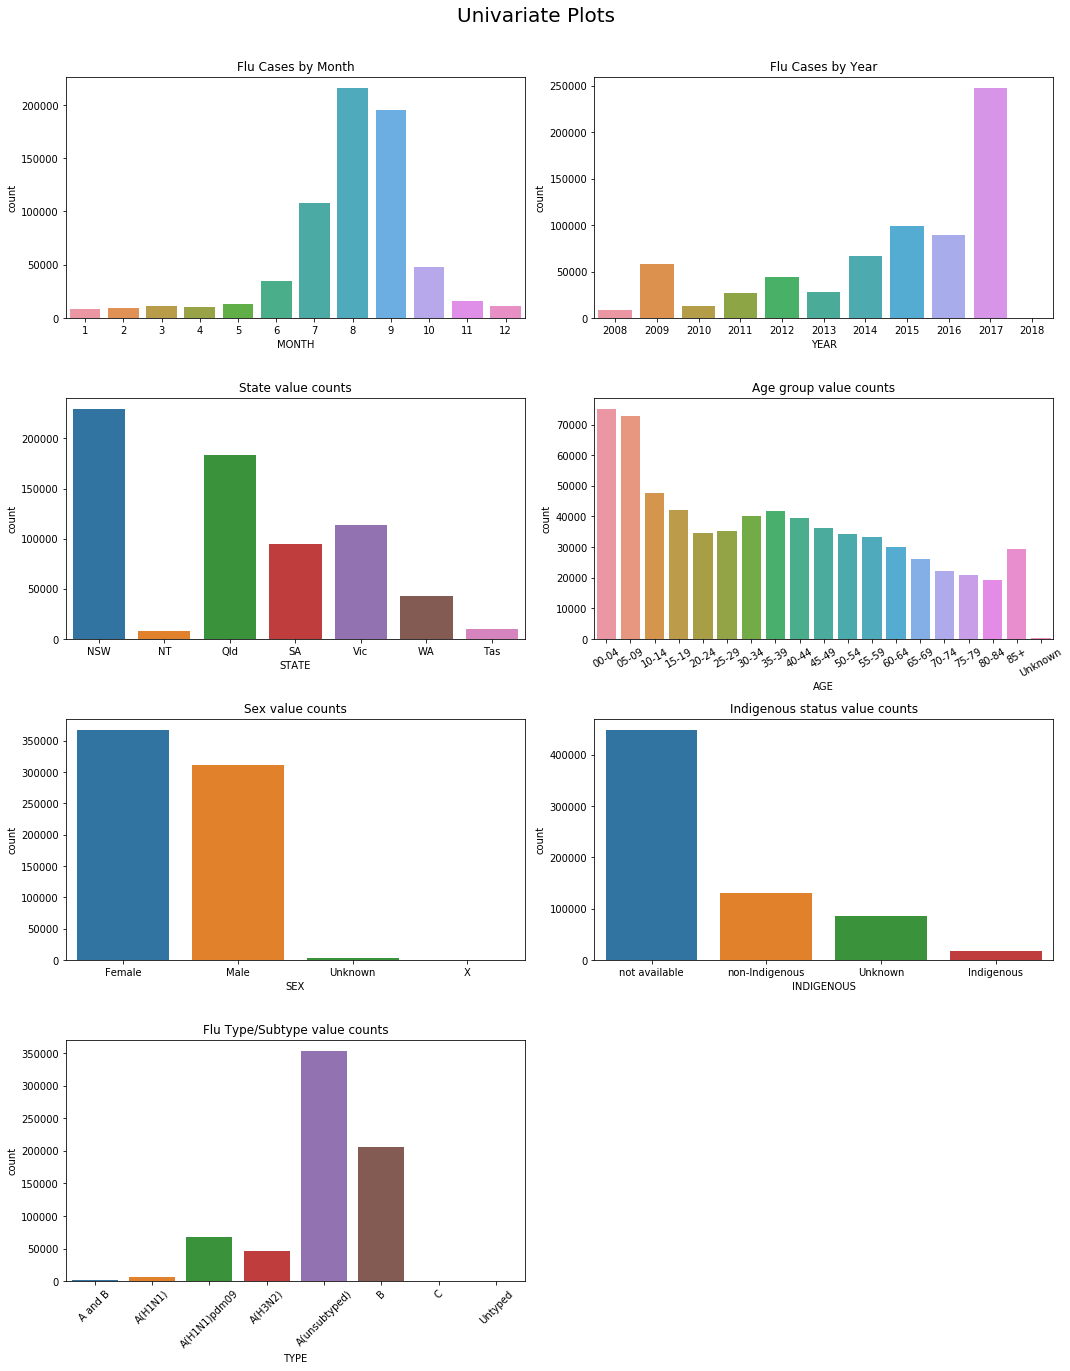

In [7]:
fig, ax = plt.subplots(figsize=(15, 20))

plt.subplot(421)
sns.countplot(flu.MONTH)
plt.title('Flu Cases by Month')

plt.subplot(422)
sns.countplot(flu.YEAR)
plt.title('Flu Cases by Year')

plt.subplot(423)
sns.countplot(flu.STATE)
plt.title('State value counts')

plt.subplot(424)
sns.countplot(flu.AGE.sort_values())
plt.xticks(rotation=30)
plt.title('Age group value counts')

plt.subplot(425)
sns.countplot(flu.SEX)
plt.title('Sex value counts')

plt.subplot(426)
sns.countplot(flu.INDIGENOUS)
plt.title('Indigenous status value counts')

plt.subplot(427)
sns.countplot(flu.TYPE.sort_values())
plt.xticks(rotation=45)
plt.title('Flu Type/Subtype value counts')

plt.suptitle('Univariate Plots', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Interesting trends we see here. The flu season in Australia, predictably, appears to take place from June through October, peaking in August. Roughly of the opposite schedule of the US flu season.

As for the year plot, I'm surprised to see a huge surge in cases in 2017. A quick Google search provides many articles regarding an unusually bad flu season that year relating to poor vaccine formulation. It's not an exact science developing vaccines, there will always be a chance the strains will have mutated or different strains will be prevalent than those protected against.

We see that less populous areas of Australia (Northern Territory and Tasmania) have fewer reported cases, which makes sense.

Unsurprisingly, we see local maxima in our age plot for younger and older patients. Getting the flu for either group is more serious.

For the SEX column we see about 5,000 more flu cases in women than men. Whether this reflects actual differences in infection rates or differences in who seeks treatment can't be said from this data.

The INDIGENOUS column seems to be the most troublesome in this data. Over 2/3 of the cases are marked "not available," or missing. Below we will explore the distribution of flu cases by indigenous status to see if anything unusual is revealed. If not, we will remove it.

The TYPE column shows multiple kinds of type A influenza and one type B are the majority of cases. Otherwise we see "A and B," "C," and "Untyped" as other options. We'll explore this more below as well, combining some of these categories.

### Handling missing/unknown data

I want to check how many cases we have for 2018. It's not a full year's data, and may end up throwing off our results. I will probably end up removing it.

In [8]:
print(flu[flu['YEAR']==2018].shape)
print(flu[flu['YEAR']==2018].groupby('MONTH').count())

(172, 7)
       STATE  AGE  SEX  INDIGENOUS  TYPE  YEAR
MONTH                                         
1        172  172  172         172   172   172


In [9]:
flu = flu[flu['YEAR']!=2018]

Let's follow that by streamlining the flu type category. We can narrow it down to Type A, which will consist of all typed and untyped A cases, and Type B, as they are the most common and of most interest to us. 

In [10]:
flu = flu[(flu['TYPE'] != 'C') & (flu['TYPE'] != 'Untyped') & (flu['TYPE'] != 'A and B')]
flu.TYPE.replace(to_replace="A\(.+", value='A', regex=True, inplace=True)
flu.TYPE.unique()

array(['A', 'B'], dtype=object)

Next I want to check out the INDIGENOUS column in relation to flu type. Because over 2/3 of the instances have "not available" as their indigenous status, it seems like a fairly useless column. Unless there are stark differences in distributions between the two variables, I don't see any reason to keep it.

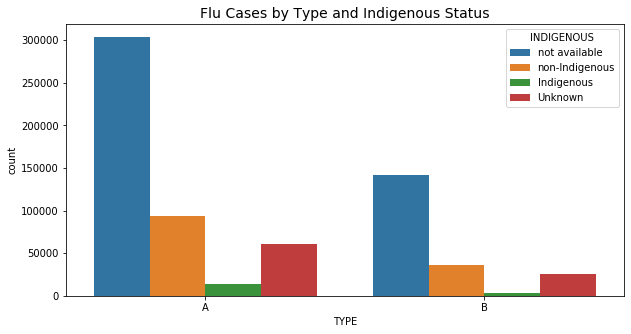

In [11]:
# Let's look at the INDIGENOUS column in more detail.
plt.figure(figsize=(10, 5))
sns.countplot(x='TYPE', hue='INDIGENOUS', data=flu)
plt.title('Flu Cases by Type and Indigenous Status', fontsize=14)
plt.show()

There's nothing unusual here...our distributions match between the two flu types, so I will go ahead and remove the column INDIGENOUS.

In [12]:
flu.drop('INDIGENOUS', axis=1, inplace=True)

Now that we have that taken care of, let's take a look at a few other smaller categories we saw on the plots above.

In [13]:
# Let's look at the categories with minimal cases from above:
print("cases with Unknown AGE:", flu[flu.AGE=='Unknown'].shape[0])
print('cases with Unknown SEX:', flu[flu.SEX=='Unknown'].shape[0])
print('cases with X SEX:', flu[flu.SEX=='X'].shape[0])

cases with Unknown AGE: 233
cases with Unknown SEX: 2597
cases with X SEX: 4


We'll start out by removing the "Unknown" AGE rows, as there are so few. Then we'll follow up with replacing "Unknown" and "X" SEX values with a catchall "NA" for patients not categorized as "M" or "F."

In [14]:
# Remove 'Unknown' age rows
flu = flu[flu['AGE'] != 'Unknown']

# Rename rows with SEX values X or Unknown as 'NA'
flu.SEX.replace(['X', 'Unknown'], 'NA', inplace=True)

print('Unique vals in AGE:', flu.AGE.unique())
print('Unique vals in SEX:', flu.SEX.unique())

Unique vals in AGE: ['00-04' '05-09' '10-14' '15-19' '20-24' '25-29' '30-34' '45-49' '50-54'
 '55-59' '65-69' '70-74' '75-79' '80-84' '85+' '40-44' '60-64' '35-39']
Unique vals in SEX: ['Female' 'Male' 'NA']


Next I'm going to pause the EDA quickly and make a dataframe of dummy columns from our cleaned up features so we can do some more sophisticated ratio plots in addition to further visualizations on the main data set.

In [15]:
# Create dataframe with dummy variables for all columns
flu_dum = pd.get_dummies(data=flu, columns=['STATE', 'AGE', 'SEX', 'MONTH', 'YEAR'])

In [16]:
sum_df = flu_dum.groupby('TYPE').sum()
sum_df.loc['TOTAL'] = sum_df.sum()
sum_df = sum_df.T
for flu_type in ['A', 'B']:
    sum_df[flu_type] = sum_df[flu_type] / sum_df.TOTAL
sum_df.head()

TYPE,A,B,TOTAL
STATE_NSW,0.664102,0.335898,227834.0
STATE_NT,0.787447,0.212553,7791.0
STATE_Qld,0.715238,0.284762,183188.0
STATE_SA,0.719532,0.280468,94385.0
STATE_Tas,0.760027,0.239973,10222.0


Now that we have that taken care of, let's continue on with our visualizations

### Bivariate Analysis

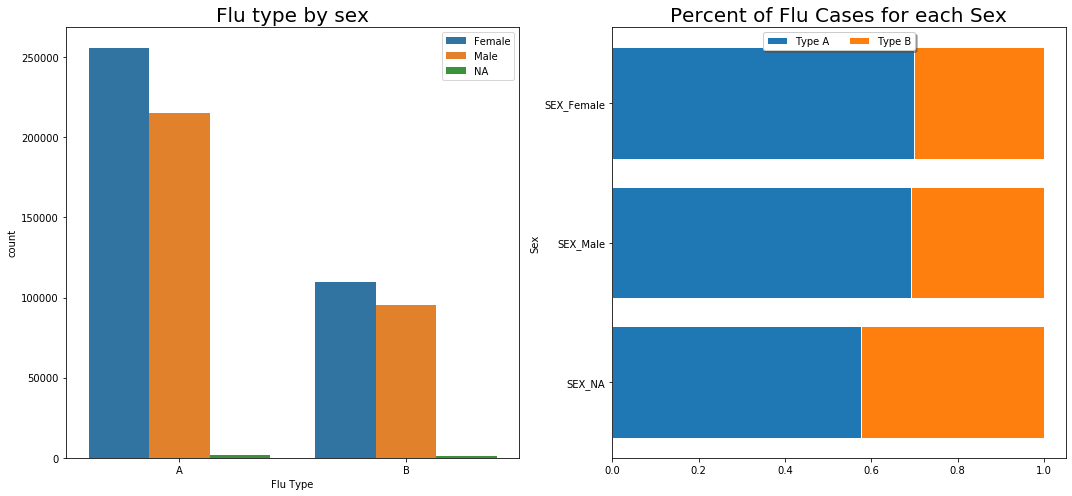

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

sns.countplot(x='TYPE', hue='SEX', data=flu, ax = ax1)
ax1.set_title('Flu type by sex', fontsize=20)
ax1.set_xlabel('Flu Type')
ax1.legend(loc='upper right')

# Plot first 50 most occurring words in BOW
flu_types = ['A', 'B']
for count, flu_type in enumerate(flu_types):
    #plot use of words for given state
    ax2.barh(sum_df.index[25:28], sum_df[flu_type][25:28], 
             left=sum_df[flu_types[:count]].sum(axis=1)[25:28],
             edgecolor='white', label=flu_type)
    
ax2.set_ylabel('Sex')
ax2.invert_yaxis()
ax2.set_title("Percent of Flu Cases for each Sex", fontsize=20)
ax2.legend(labels=['Type A', 'Type B'], loc='upper center', bbox_to_anchor=(0.5, 1.00),
          ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

Here we see consistently higher rates among women and of type A flu. As far as percentages, males and females showed almost identical ratios of the two kinds of flu (around 70% of cases type A), while the NA sex group had much higher percentage of type B.

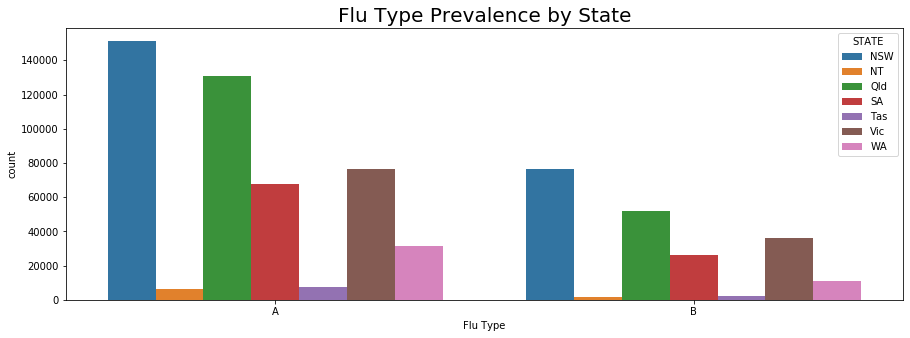

In [18]:
plt.figure(figsize=(15, 5))
sns.countplot(x="TYPE", hue='STATE', data=flu)
plt.xlabel('Flu Type')
plt.title('Flu Type Prevalence by State', fontsize=20)
plt.show()

Between the two types of flu, we see very similar distribution of cases across all the states. 

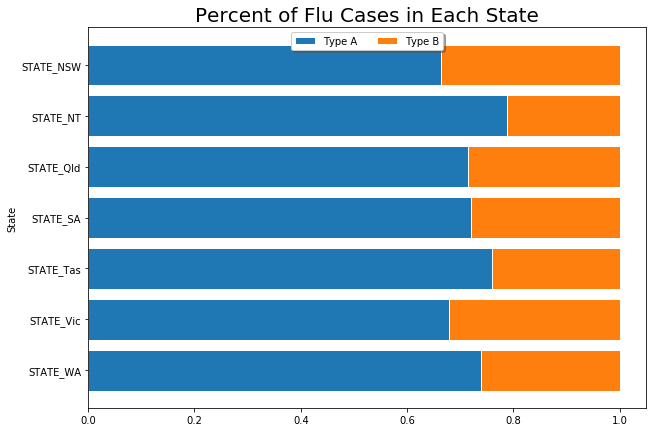

In [19]:
# Plot first 50 most occurring words in BOW
fig, ax = plt.subplots(figsize=(10, 7))

for count, flu_type in enumerate(flu_types):
    #plot use of words for given state
    ax.barh(sum_df.index[:7], sum_df[flu_type][:7], 
             left=sum_df[flu_types[:count]].sum(axis=1)[:7],
             edgecolor='white', label=flu_type)
    
ax.set_ylabel('State')
ax.invert_yaxis()
ax.set_title("Percent of Flu Cases in Each State", fontsize=20)
ax.legend(labels=['Type A', 'Type B'], loc='upper center', bbox_to_anchor=(0.5, 1.00),
          ncol=5, fancybox=True, shadow=True)
plt.show()

In the ratio plot, we see all the states have very close distributions. Northern Territory (NT) has the highest percentage of Influenza A around 78%, while New South Wales has the lowest percentage of Influenza A around 66%.

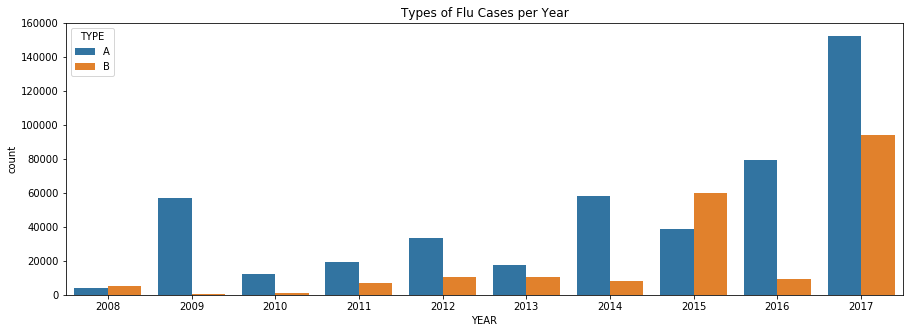

In [20]:
plt.figure(figsize=(15, 5))
sns.countplot(x='YEAR', hue='TYPE', data=flu)
plt.title('Types of Flu Cases per Year')
plt.show()

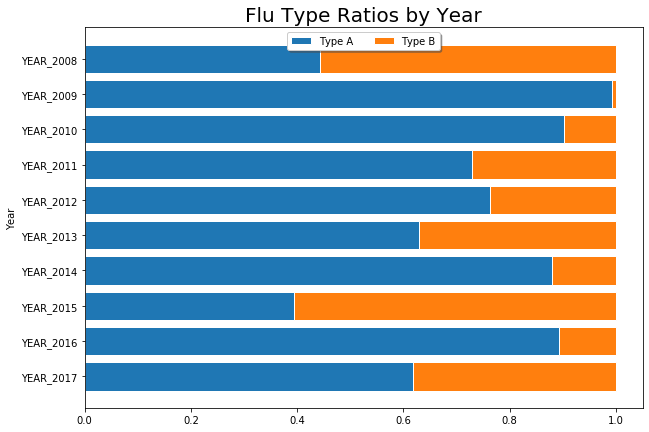

In [21]:
# Plot first 50 most occurring words in BOW
fig, ax = plt.subplots(figsize=(10, 7))
for count, flu_type in enumerate(flu_types):
    #plot use of words for given state
    plt.barh(sum_df.index[40:], sum_df[flu_type][40:], 
             left=sum_df[flu_types[:count]].sum(axis=1)[40:],
             edgecolor='white', label=flu_type)
    
ax.set_ylabel('Year')
ax.invert_yaxis()
ax.set_title("Flu Type Ratios by Year", fontsize=20)
ax.legend(labels=['Type A', 'Type B'], loc='upper center', bbox_to_anchor=(0.5, 1.00),
          ncol=5, fancybox=True, shadow=True)
plt.show()

We can see the 2017 season looks particularly bad because there were the highest recorded levels of both types of influenza. The ratio plot clarifies the above, showing us diagnosed cases in 2009 were almost entirely type A. There's quite a range in our ratios, year to year. 


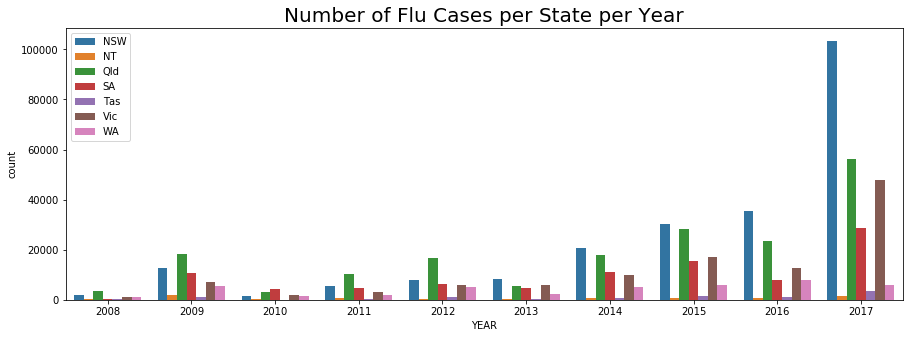

In [22]:
plt.figure(figsize=(15, 5))
sns.countplot(x='YEAR', hue='STATE', data=flu)
plt.title('Number of Flu Cases per State per Year', fontsize=20)
plt.legend(loc="upper left")
plt.show()


It appears that in recent years, New South Wales has had the majority of recorded flu cases, but 2017 there were almost twice as many cases there than the next highest state. As mentioned above, I was able to find that 2017 was an expecially bad season, but smaller variations in years prior may be caused by many other factors than just severity of the flu season. It's possible that more recently, say in 2014, the Australian Department of Health started a flu awareness campaign encouraging people to seek treatment and flu shots, which could explain the growth from 2014 to 2017. I'm sure there are plenty of confounding factors we don't have access to, but we must see what we can determine with this data.

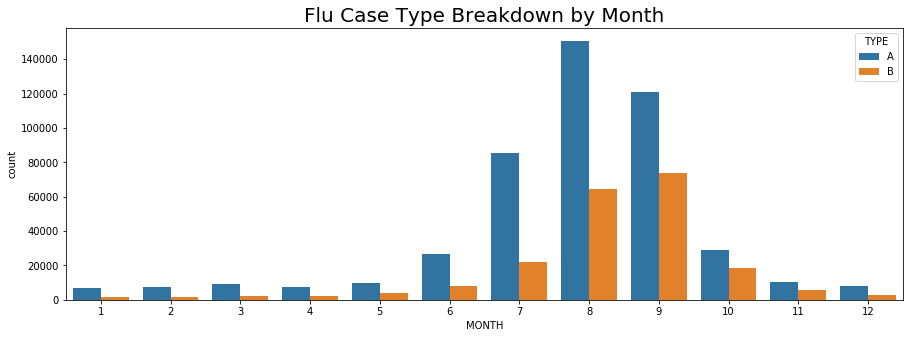

In [23]:
plt.figure(figsize=(15, 5))
sns.countplot(x='MONTH', hue='TYPE', data=flu)
plt.title('Flu Case Type Breakdown by Month', fontsize=20)
plt.show()

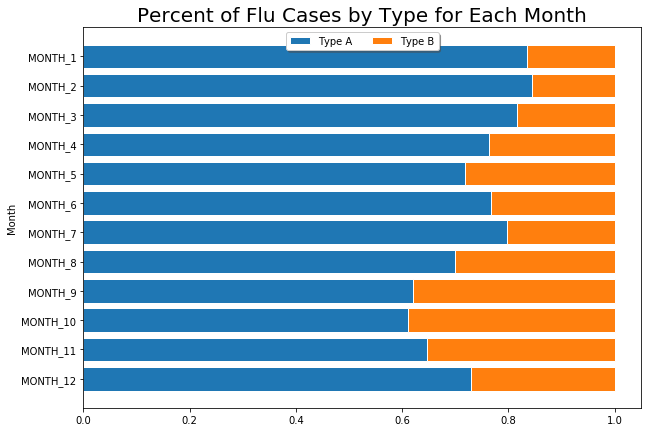

In [24]:
# Plot first 50 most occurring words in BOW
fig, ax = plt.subplots(figsize=(10, 7))
for count, flu_type in enumerate(flu_types):
    #plot use of words for given state
    plt.barh(sum_df.index[28:40], sum_df[flu_type][28:40], 
             left=sum_df[flu_types[:count]].sum(axis=1)[28:40],
             edgecolor='white', label=flu_type)
    
ax.set_ylabel('Month')
ax.invert_yaxis()
ax.set_title("Percent of Flu Cases by Type for Each Month", fontsize=20)
ax.legend(labels=['Type A', 'Type B'], loc='upper center', bbox_to_anchor=(0.5, 1.00),
          ncol=5, fancybox=True, shadow=True)
plt.show()

Influenza A is the most common type, both plots show this across all months. The two types peak at different times, though, which is interesting. It looks like influenza B came on slightly later than type A.


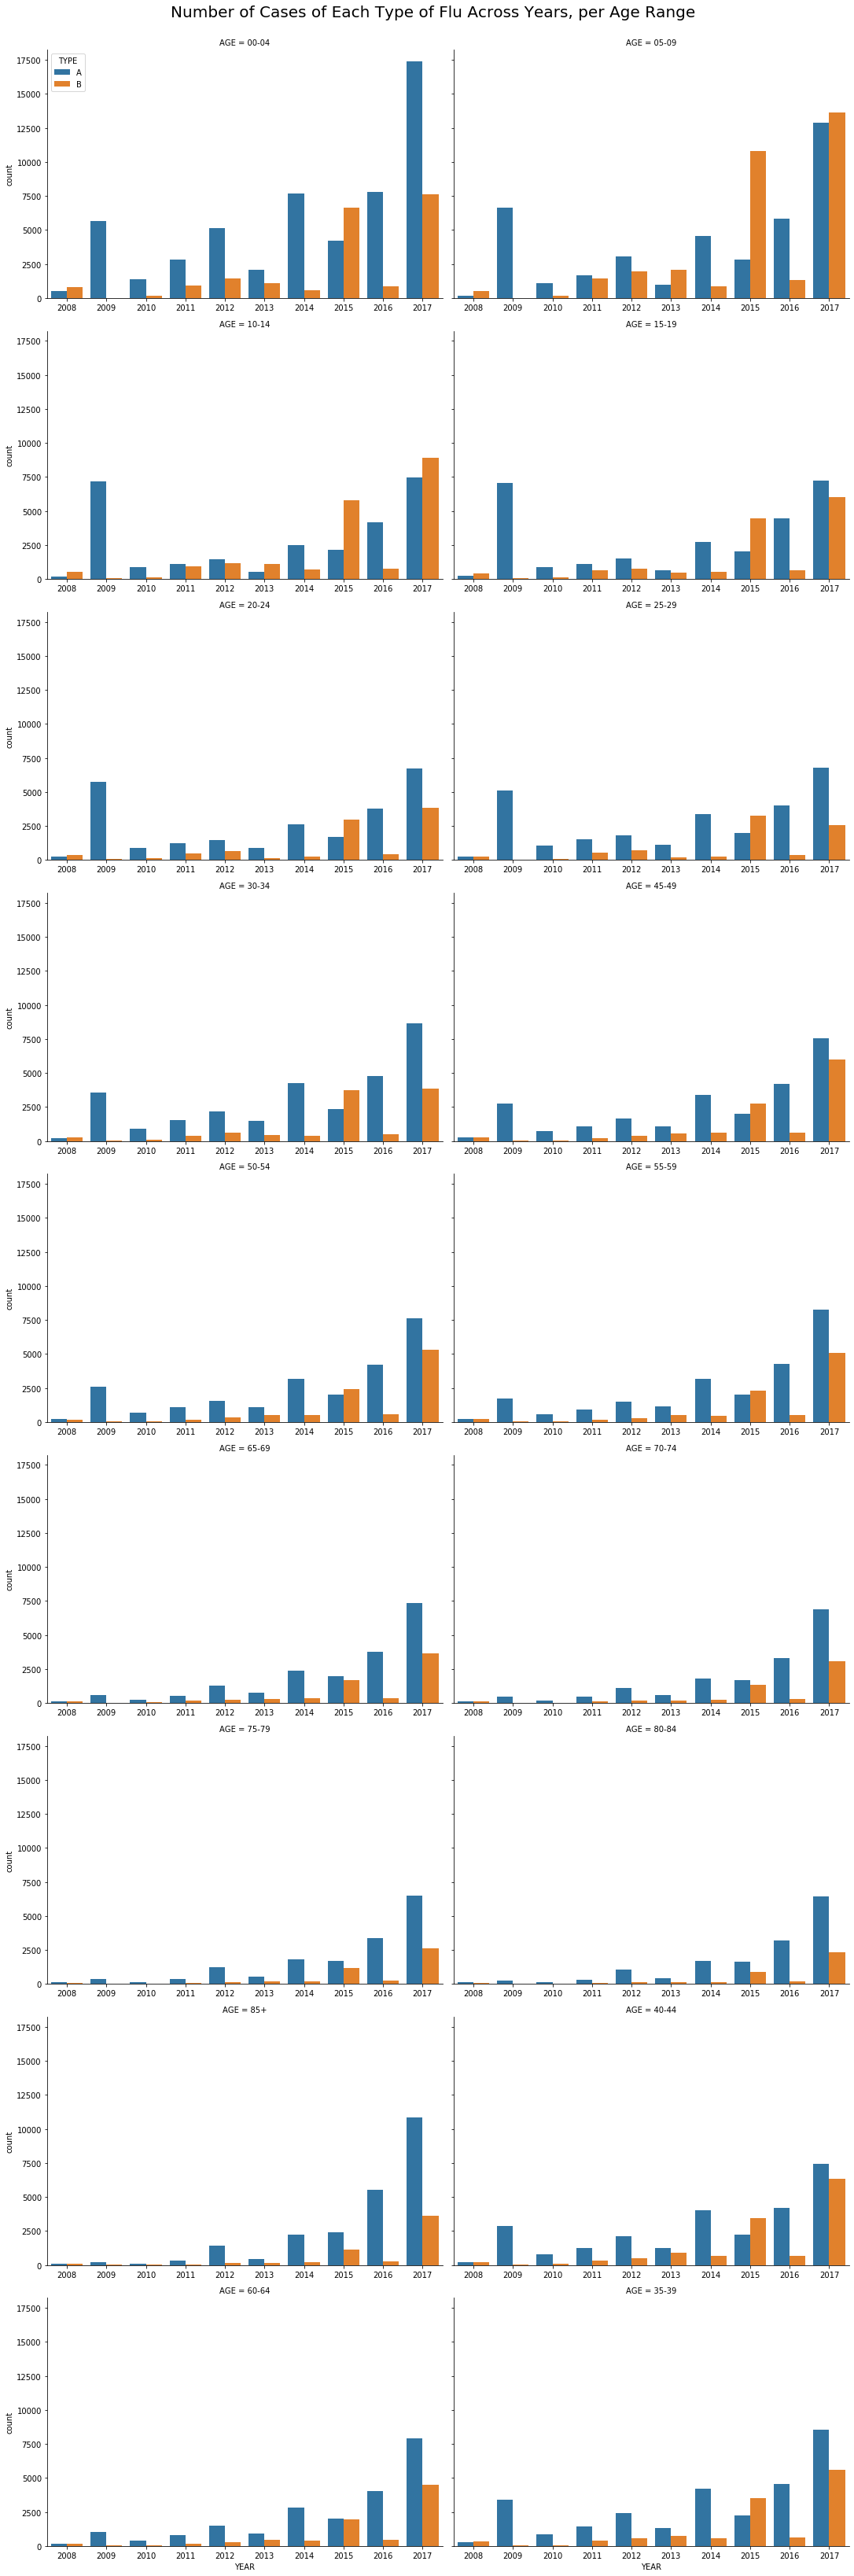

In [25]:
# Curious to see if a plot of flu cases by type, grouped by age, over time will be informative
sns.catplot(x='YEAR', hue='TYPE', col='AGE', col_wrap=2, data=flu, kind='count', 
            height=5, aspect=1.5, sharex=False, legend_out=False)
plt.suptitle('Number of Cases of Each Type of Flu Across Years, per Age Range', y=1.01, fontsize=20)

plt.show()

Interesting to note that in 2017, the 5-9 and 10-14 age ranges had higher instances of influenza B than A, unlike the rest of the age groups. I'm curious if it has something to do with transmittance during school, sports, or other youth activities.

Let's try a Heatmap to wrap things up for now.

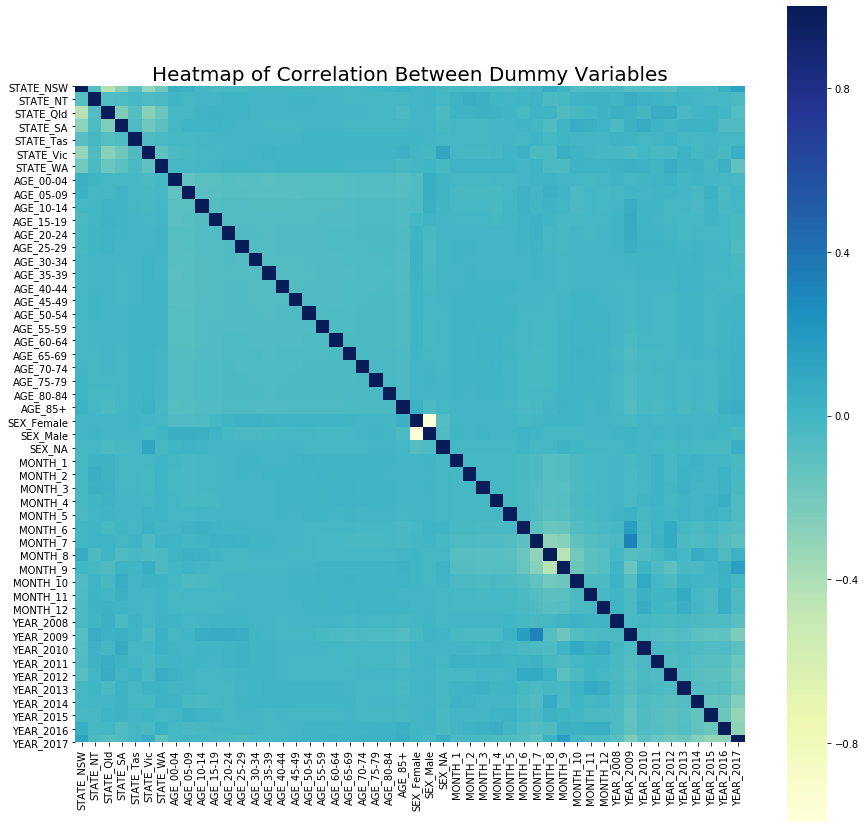

In [26]:
plt.figure(figsize=(15, 15))
sns.heatmap(flu_dum.corr(), square=True, cmap='YlGnBu')
plt.title('Heatmap of Correlation Between Dummy Variables', fontsize=20)
plt.show()

Everything looks pretty consistently uncorrelated, other than SEX. We can see that Female and Male have a correlation of -1, or complete exclusivity. Sounds right.

## 4. Data Preprocessing

Below we'll split our data using StratifiedShuffleSplit (to maintain equal distribution of categorical variables) and create a test subset that we'll reserve for final model evaluation. We'll create 3 such train-test splits: 

    "flu" will be our main dataset (no X/y distinction) formatted for Pymer4, which takes a function parameter, 
    "X,y" will have target and predictor variables separated, and 
    "XD,yd" will be the dummy version of the above.

In [27]:
# Create X and y variables, non-dummy
X = flu.drop('TYPE', axis=1)
y = flu.TYPE

# Remove underscores from dummy column names to match Pymer4 format later on
flu_dum.rename(columns=lambda x: x.replace('_', ''), inplace=True)
# Create X and y variables, dummy
X_dum = flu_dum.drop('TYPE', axis=1)
y_dum = flu_dum.TYPE

# Create SSS instance
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=5588)
for train_index, test_index in sss.split(X, y):
    # Split Flu data set
    flu_train, flu_test = flu.iloc[train_index].copy(), flu.iloc[test_index].copy()
    # Split Flu data set with predictors and target variable
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    # Split one-hot encoded flu data set with predictors and target variable
    XD_train, XD_test = X_dum.iloc[train_index].copy(), X_dum.iloc[test_index].copy()
    yd_train, yd_test = y_dum.iloc[train_index].copy(), y_dum.iloc[test_index].copy()

# Create 4 equal subsections of the training set to verify model consistency
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dum)


# First split in half, then halve each half
x1, x2, xpca1, xpca2 = train_test_split(X_dum, X_pca, test_size=0.5, shuffle=True, random_state=5588)
X1, X2, XPCA1, XPCA2 = train_test_split(x1, xpca1, test_size=0.5, shuffle=True, random_state=5588)
X3, X4, XPCA3, XPCA4 = train_test_split(x2, xpca2, test_size=0.5, shuffle=True, random_state=5588)

subsets = [X1, X2, X3, X4]


### Create cluster feature

As an additional feature, we'll create a "CLUSTER" column, which we'll populate with the output of a KMeans algorithm. First we'll determine the ideal number of clusters to create using the elbow method. 

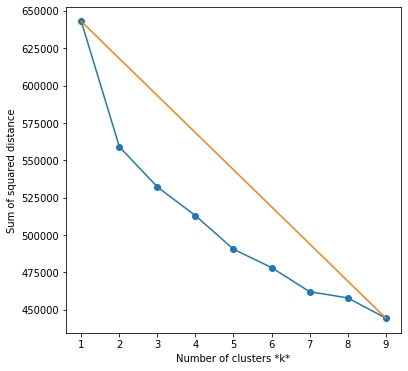

Optimal number of clusters: 3


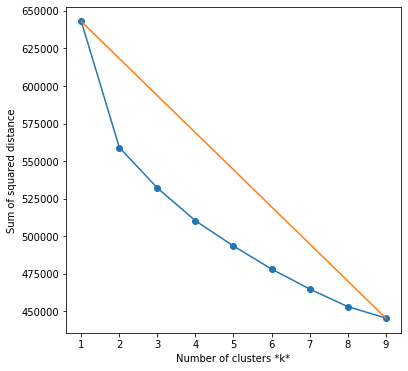

Optimal number of clusters: 3


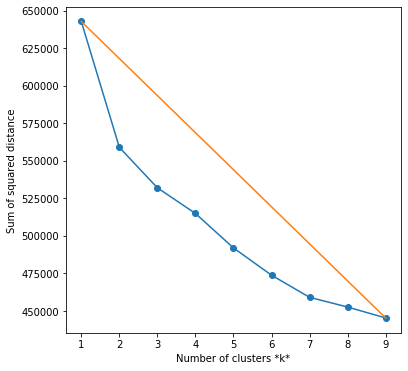

Optimal number of clusters: 3


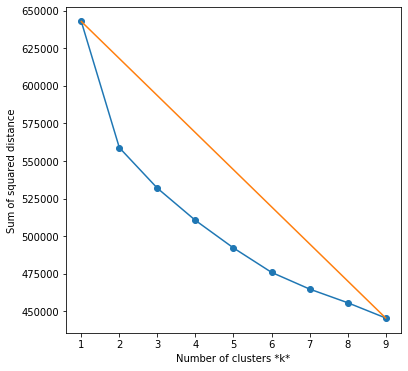

Optimal number of clusters: 3


In [28]:
# Run and plot elbow method analysis for each of the 4 subgroups
it = 1
K = range(1, 10)
for X in subsets:
    sse = []
    list_k = list(range(1, 10))

    for k in list_k:
        km = KMeans(n_clusters=k, random_state=5588)
        km.fit(X)
        sse.append(km.inertia_)

    # Create coordinates for line segment to plot start point to end point
    x1, y1 = 1, sse[0]
    x2, y2 = 9, sse[-1]
    
    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o')
    plt.plot((x1, x2), (y1, y2))
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance');# Determine distortion for each value of k clusters
    plt.show()
    
    # Determing optimal cluster size, best balance between within-cluster homogeneity and 
    # cluster diversity by finding point furthest from straight line (x1, y1), (x2, y2)
    distances = []
    for i in range(len(sse)):
        x0 = i + 1
        y0 = sse[i]
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2* x1)
        denominator = ((y2 - y1)**2 + (x2 - x1)**2)**0.5
        distances.append(numerator/denominator)
    # Return best n_clusters value
    print('Optimal number of clusters:', distances.index(max(distances)) + 1)
    it += 1

Alright, we'll use a 3 cluster model. We'll be performing a fit only on the training data, then use this model to predict clusters for both the train and test sets. 

In [29]:
# Instantiate, fit, and predict with KMeans model
# Uncomment to alter
#kmean = KMeans(n_clusters=3, random_state=5588)
#kmean.fit(XD_train)

In [30]:
# Uncomment to alter
#abspath = pathlib.Path('kmean_capstone.pkl').absolute()
#with open(str(abspath), 'wb') as f:
#    pickle.dump(kmean, f)

In [31]:
with open('kmean_capstone.pkl', "rb") as input_file:
     kmean = pickle.load(input_file)

In [32]:
# Predict clusters using fit model
clust_train = kmean.predict(XD_train)
clust_test = kmean.predict(XD_test)

# Append cluster column to all training dataframes
flu_train.loc[:, 'CLUSTER'] = clust_train
X_train.loc[:, 'CLUSTER'] = clust_train
XD_train.loc[:, 'CLUSTER'] = clust_train
XD_train = pd.get_dummies(XD_train, columns=['CLUSTER'])
XD_train.rename(columns=lambda x: x.replace('_', ''), inplace=True)

# Append cluster column to all test dataframes
flu_test.loc[:, 'CLUSTER'] = clust_test
X_test.loc[:, 'CLUSTER'] = clust_test
XD_test.loc[:, 'CLUSTER'] = clust_test
XD_test = pd.get_dummies(XD_test, columns=['CLUSTER'])
XD_test.rename(columns=lambda x: x.replace('_', ''), inplace=True)

## 5. Modeling

### Mixed Effects Modeling

The social sciences typically use a set of complex statistical models called Generalized Linear Mixed Models (GLMMs). GLMMs are an expansion of linear regression (can also be logistic) to include random effects as well as the traditional fixed effects (where the "mixed" part comes from). Random effects allow the user to account for variance between different levels of a categorical variable by calculating unique intercepts, slopes, or both for each level. In this case, I treated "STATE" as a random effect, and had the Lmer (Linear mixed effects regression) calculate different intercepts per state. 

In [33]:
# Convert to string then cat so the wrapper can seamlessly convert from Python 'category' to R 'factor'
flu_train = flu_train.applymap(str)
#flu_train = flu_train.astype('category')
# Convert test sets as well
flu_test = flu_test.applymap(str)
#flu_test = flu_test.astype('category')

In [34]:
# Uncomment to alter
#model = Lmer('TYPE ~ STATE + AGE + SEX + MONTH + YEAR + CLUSTER + (1|STATE)', data=flu_train, family='binomial')
#model.fit()

Here we have a base/intercept patient who is female from New South Wales, in the Age 00-04 group, who was diagnosed in January of the year 2008, and is in cluster 0.

### Pickling model

In [35]:
# Uncomment to alter
#abspath = pathlib.Path('pymer4capstone.pkl').absolute()
#with open(str(abspath), 'wb') as f:
#    pickle.dump(model, f)

In [36]:
# Load Pymer4 model pickle
with open('pymer4capstone.pkl', "rb") as input_file:
     model = pickle.load(input_file)
  
# print model summary
model.summary()

Formula: TYPE~STATE+AGE+SEX+MONTH+YEAR+CLUSTER+(1|STATE)

Family: binomial	 Inference: parametric

Number of observations: 543225	 Groups: {'STATE': 7.0}

Log-likelihood: -272816.771 	 AIC: 545731.543

Random effects:

              Name  Var  Std
STATE  (Intercept)  0.0  0.0

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.687,-0.773,-0.602,0.043,0.503,0.462,0.548,0.335,0.316,0.354,-15.816,0.000,***
STATENT,-0.195,-0.268,-0.123,0.037,0.823,0.765,0.884,0.451,0.433,0.469,-5.293,0.000,***
STATEQld,-0.219,-0.236,-0.202,0.009,0.804,0.790,0.817,0.446,0.441,0.450,-25.133,0.000,***
STATESA,-0.306,-0.328,-0.285,0.011,0.736,0.721,0.752,0.424,0.419,0.429,-28.203,0.000,***
STATETas,-0.498,-0.556,-0.441,0.029,0.607,0.574,0.643,0.378,0.365,0.391,-17.034,0.000,***
STATEVic,-0.158,-0.177,-0.139,0.010,0.854,0.838,0.871,0.461,0.456,0.465,-16.130,0.000,***
STATEWA,-0.093,-0.123,-0.062,0.016,0.911,0.884,0.939,0.477,0.469,0.484,-5.987,0.000,***
AGE05-09,0.885,0.858,0.912,0.014,2.423,2.358,2.490,0.708,0.702,0.713,64.071,0.000,***
AGE10-14,0.913,0.883,0.944,0.016,2.493,2.417,2.571,0.714,0.707,0.720,57.981,0.000,***
AGE15-19,0.559,0.526,0.592,0.017,1.749,1.693,1.807,0.636,0.629,0.644,33.445,0.000,***


### Model evaluation

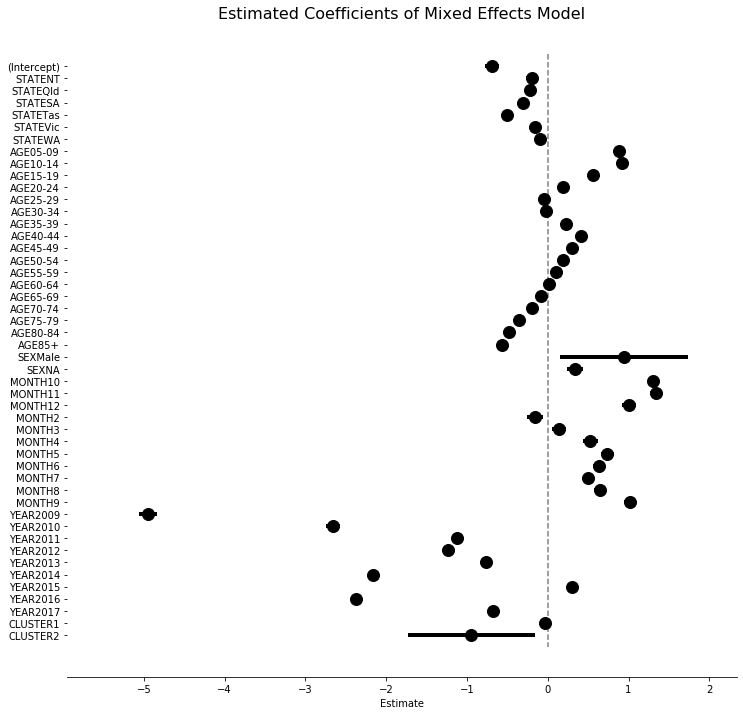

In [37]:
model.plot_summary(figsize=(12, 12))
plt.title('Estimated Coefficients of Mixed Effects Model', fontsize=16)
plt.show()

We see expected trends in the coefficients that for the most part follow our univariate plots. Nothing is very surprising. Any of the small deviations from said distributions could probably be attributed to the STATE random effect (such as AGE 85+ not reflecting the increase we saw on the count plot in our univariate analysis section). We also see that CLUSTER2 shares the same wide confidence interval as the SEXMale category, so perhaps it contains all the same points.

From the summary table above, the far right two columns, P-Value and Significance, tell us that AGE30-34 and AGE60-64 have no significance. Low significance features are AGE25-29, SEXMale, CLUSTER1, and CLUSTER2. 

In [38]:
model.anova()

SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)


/opt/anaconda3/lib/python3.7/site-packages/pymer4/models/Lmer.py:210: UserWarning: MODELING FIT WARNING! Check model.warnings!! P-value computation did not occur because lmerTest choked. Possible issue(s): ranefx have too many parameters or too little variance...
  "MODELING FIT WARNING! Check model.warnings!! P-value computation did not occur because lmerTest choked. Possible issue(s): ranefx have too many parameters or too little variance..."


,DF,SS,MS,F-stat
STATE,6,716.982551,119.497092,119.497092
AGE,17,10362.854961,609.579704,609.579704
SEX,2,67.435178,33.717589,33.717589
MONTH,11,5104.975101,464.088646,464.088646
YEAR,9,59528.664935,6614.296104,6614.296104
CLUSTER,2,7.827918,3.913959,3.913959


Unfortunately the ANOVA did not give us P-values and I was unable to, through any parameter tuning, obtain them. Thus, we can't create a null hypothesis test, but we can inspect the F-statistics. The YEAR category shows the most variance within samples. We did see a very extreme number of verified cases in the 2017 flu season, and very few in 2008 and 2010. The plot is pictured below to illustrate this.

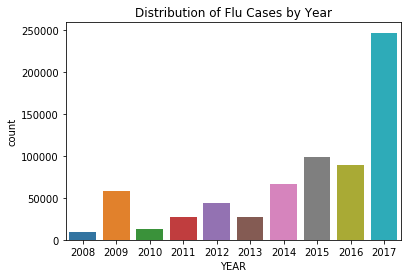

In [39]:
sns.countplot(x='YEAR', data=flu)
plt.title("Distribution of Flu Cases by Year")
plt.show()

### Attempt to predict:

In [40]:
XD_test = XD_test.applymap(str)
y_pred = model.predict(XD_test[list(model.design_matrix.columns[1:])])#.astype('category'))

In [41]:
print('shape of data going into model.predict:', XD_test[list(model.design_matrix.columns[1:])].astype('category').shape)
print('shape of model.predict output, y_pred:', y_pred.shape)
print('flu_train_shape:', flu_train.shape)
print('XD_test_shape:', XD_test.shape)

shape of data going into model.predict: (135807, 47)
shape of model.predict output, y_pred: (543225,)
flu_train_shape: (543225, 7)
XD_test_shape: (135807, 53)


I tried to use my test data set to evaluate the model's accuracy, but ran into issues with data of different lengths. When I ran the model.predict() method on my test data, the returned array was the length of the training data set. There is more about this in the summary below, but suffice to say, lack of support and my own knowledge with R as well as a tight timeline led to an unsolvable issue.

In [42]:
results = pd.DataFrame(columns=['accuracy'])
results.loc['Pymer4'] = np.nan
results

,accuracy
Pymer4,NaN


## Logistic Regression


In [43]:
# Instantiate and fit model
"""logreg = LogisticRegression(penalty='l2',
                        solver='lbfgs',
                        C=100,
                        max_iter=500,
                        random_state=5588)
logreg.fit(XD_train.drop(['STATENSW', 'AGE00-04', 'SEXFemale', 'MONTH1', 'YEAR2008', 'CLUSTER0'], axis=1), yd_train)"""


"logreg = LogisticRegression(penalty='l2',\n                        solver='lbfgs',\n                        C=100,\n                        max_iter=500,\n                        random_state=5588)\nlogreg.fit(XD_train.drop(['STATENSW', 'AGE00-04', 'SEXFemale', 'MONTH1', 'YEAR2008', 'CLUSTER0'], axis=1), yd_train)"

In [44]:
# Pickle model
#abspath = pathlib.Path('logreg_capstone.pkl').absolute()
#with open(str(abspath), 'wb') as f:
#    pickle.dump(logreg, f)

In [45]:
# Load model
with open('logreg_capstone.pkl', "rb") as input_file:
     logreg = pickle.load(input_file)

In [51]:
import statsmodels.discrete.discrete_model as discrete
convert_dict = {'A':1, 'B':0}

logit_model=discrete.Logit(yd_train.map(convert_dict), XD_train.drop(['STATENSW', 'AGE00-04', 
                                            'SEXFemale', 'MONTH1', 'YEAR2008', 'CLUSTER0'], axis=1).astype(float))
result=logit_model.fit(maxiter=1000)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.502448
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   TYPE   No. Observations:               543225
Model:                          Logit   Df Residuals:                   543178
Method:                           MLE   Df Model:                           46
Date:                Sat, 16 Nov 2019   Pseudo R-squ.:                  0.1822
Time:                        12:59:10   Log-Likelihood:            -2.7294e+05
converged:                       True   LL-Null:                   -3.3376e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
STATENT        0.2282      0.037      6.187      0.000       0.156       0.300
STATEQld       0.2367      0.

In [46]:
# Generate prediction on test data
logreg_pred = logreg.predict(XD_test.drop(['STATENSW', 'AGE00-04', 'SEXFemale',
                                       'MONTH1', 'YEAR2008', 'CLUSTER0'], axis=1))
# Accuracy table
table = pd.crosstab(yd_test, logreg_pred)

# Print prediction accuracy table and accuracy score
print('\n Accuracy by Flu Type')
print(table)
print('\n Percentage accuracy')
logreg_accuracy = round(accuracy_score(yd_test, logreg_pred) * 100, 2) 
print(logreg_accuracy)


 Accuracy by Flu Type
col_0      A      B
TYPE               
A      84178  10313
B      24671  16645

 Percentage accuracy
74.24


In [47]:
print('percent of TYPE B cases incorrectly predicted:', round(table.iloc[1, 0] / table.sum(axis=1)[1] * 100, 2))

percent of TYPE B cases incorrectly predicted: 59.71


In [48]:
results.loc['Log Reg'] = logreg_accuracy
results

,accuracy
Pymer4,NaN
Log Reg,74.24


### Logistic Regression Results
So with a basic logistic regression model, we were able to achieve 74% accuracy. Not bad, considering there were few columns and features to start with. Probably due to our unbalanced dataset, of the cases that were actually TYPE B, we predicted 60% of them wrong.

We also have over twice as many Type II errors as Type I, which could be a big problem, depending on the application. First, I want to compare coefficient values for the Mixed Model above and our Logistic Regression. After that I'll try balancing our training data set using oversampling, and create another logistic regression model to compare.

#### Feature Importance
From our P-values, we can see that the categories AGE60-64, SEXMale, and CLUSTER2 are above the standard 0.05 level of significance, and are not adding information to our model. This matches the results from the GLMM model above, aside from leaving out CLUSTER1. Otherwise, all other categories are significant to our prediction.

In [52]:
# Create dataframe of coefficients for Lmer and Logistic Regression models
coef_df = round(model.coefs.iloc[:, 0].copy(), 3)
coef_df = pd.DataFrame(coef_df)
coef_df.rename({'Estimate':'pymer'}, axis=1, inplace=True)

# build list of logreg coefficients in same format as model.coefs indices to append
logreg_vals = [round(i, 3) for i in chain.from_iterable(logreg.coef_)]
logreg_vals.insert(0, round(logreg.intercept_.item(), 2))

coef_df['logreg'] = logreg_vals
coef_df['diff_pymer-logreg'] = coef_df['pymer'] - coef_df['logreg']
coef_df

,pymer,logreg,diff_pymer-logreg
(Intercept),-0.687,-0.680,-0.007
STATENT,-0.195,-0.196,0.001
STATEQld,-0.219,-0.219,0.000
STATESA,-0.306,-0.306,0.000
STATETas,-0.498,-0.499,0.001
STATEVic,-0.158,-0.158,0.000
STATEWA,-0.093,-0.093,0.000
AGE05-09,0.885,0.885,0.000
AGE10-14,0.913,0.914,-0.001
AGE15-19,0.559,0.559,0.000


It's interesting to notice these trends. It appears that the "MONTH" dummy columns were the only ones where the two models' coefficients different significantly.

### Logistic Regression with balanced training data

In [53]:
os = SMOTE(random_state=5588, n_jobs=-1)
columns = XD_train.columns
os_XD_train, os_yd_train = os.fit_sample(XD_train, yd_train)
os_XD_train = pd.DataFrame(data=os_XD_train, columns=columns )
os_yd_train= pd.DataFrame(data=os_yd_train, columns=['TYPE'])

# Double check results
print("length of oversampled data:", len(os_XD_train))
print('number of Type A cases:', len(os_yd_train[os_yd_train['TYPE']=='A']))
print('number of Type B cases:', len(os_yd_train[os_yd_train['TYPE']=='B']))


length of oversampled data: 755922
number of Type A cases: 377961
number of Type B cases: 377961


Now that we have nice looking balanced data, let's model and evaluate

In [ ]:
'''lr2 = LogisticRegression(penalty='l2',
                        solver='lbfgs',
                        C=100,
                        max_iter=1000,
                        random_state=5588)
lr2.fit(os_XD_train.drop(['STATENSW', 'AGE00-04', 'SEXFemale',
                                       'MONTH1', 'YEAR2008', 'CLUSTER0'], axis=1), os_yd_train['TYPE'])'''

In [ ]:
# Pickle model
#abspath = pathlib.Path('bal_logreg_capstone.pkl').absolute()
#with open(str(abspath), 'wb') as f:
#    pickle.dump(lr2, f)

In [54]:
# Load model
with open('bal_logreg_capstone.pkl', "rb") as input_file:
     lr2 = pickle.load(input_file)

In [56]:
# Generate predictions from model
os_logreg_pred = lr2.predict(XD_test.drop(['STATENSW', 'AGE00-04', 'SEXFemale',
                                       'MONTH1', 'YEAR2008', 'CLUSTER0'], axis=1))
# Print Accuracy table and score
table = pd.crosstab(yd_test, os_logreg_pred)

print('\n Accuracy table of flu type predictions')
print(table)
print('\n Percentage accuracy')
os_logreg_accuracy = round(accuracy_score(yd_test, os_logreg_pred) * 100, 2)
print(os_logreg_accuracy)


 Accuracy table of flu type predictions
col_0      A      B
TYPE               
A      63938  30553
B      10966  30350

 Percentage accuracy
69.43


In [57]:
# Add score to results table
results.loc['Log Reg (Balanced)'] = os_logreg_accuracy
results

,accuracy
Pymer4,NaN
Log Reg,74.24
Log Reg (Balanced),69.43


I'm a bit surprised to see that our model using balanced data performed worse overall as it had a larger pool of training data. It does, however, offer a tradeoff. If we are in a case where correctly predicting cases of Type B flu (reducing type II error) is most important it could prove to be the better model.

Next let's try a random forest model to compare predictive accuracy with our first logarithmic regression model.

## Random Forest Classifier

### GridSearchCV Hyperparameter Tuning

In [58]:
# Create testing parameter grid and run gridsearch
'''param_grid = {'n_estimators': [10, 100, 1000, 1500],
              'max_depth': [4, 10, None],
              }

grid_rfc = RandomForestClassifier(random_state=5588)

grid_search = GridSearchCV(grid_rfc, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(XD_train, yd_train)'''

"param_grid = {'n_estimators': [10, 100, 1000, 1500],\n              'max_depth': [4, 10, None],\n              }\n\ngrid_rfc = RandomForestClassifier(random_state=5588)\n\ngrid_search = GridSearchCV(grid_rfc, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)\ngrid_search.fit(XD_train, yd_train)"

In [59]:
# Pickle Random Forest model
#abspath = pathlib.Path('gridsearch_capstone.pkl').absolute()
#with open(str(abspath), 'wb') as f:
#    pickle.dump(grid_search, f)
    

In [60]:
# Load Random Forest pickle
with open('gridsearch_capstone.pkl', "rb") as input_file:
     grid_search = pickle.load(input_file)
        
print('Best parameters from GridSearchCV:', grid_search.best_params_)


Best parameters from GridSearchCV: {'max_depth': None, 'n_estimators': 1500}


### Instantiate and Fit RFC Model

In [61]:
#Create Random Forest from best results of GridSearchCV
'''rfc = RandomForestClassifier(n_estimators=1500, max_depth=None, n_jobs=-1, random_state=5588)
rfc.fit(XD_train, yd_train)'''

'rfc = RandomForestClassifier(n_estimators=1500, max_depth=None, n_jobs=-1, random_state=5588)\nrfc.fit(XD_train, yd_train)'

In [62]:
# Pickle random forest classifier
#abspath = pathlib.Path('rfc_capstone.pkl').absolute()
#with open(str(abspath), 'wb') as f:
#    pickle.dump(rfc, f)

In [63]:
# Load random forest classifier
with open('rfc_capstone.pkl', "rb") as input_file:
     rfc = pickle.load(input_file)

# Predict flu type in test data
rfc_pred = rfc.predict(XD_test)     


In [64]:
results.loc['Random Forest'] = round(accuracy_score(yd_test, rfc_pred) * 100, 2)
results

,accuracy
Pymer4,NaN
Log Reg,74.24
Log Reg (Balanced),69.43
Random Forest,75.63


It looks like the best accuracy goes to random forest, which beat logistic regression by 1.4 percent. 

### Feature Importance
Finally, we'll look at the feature importance of our Random Forest model and see if there are any similarities or differences to the previous 2 models.

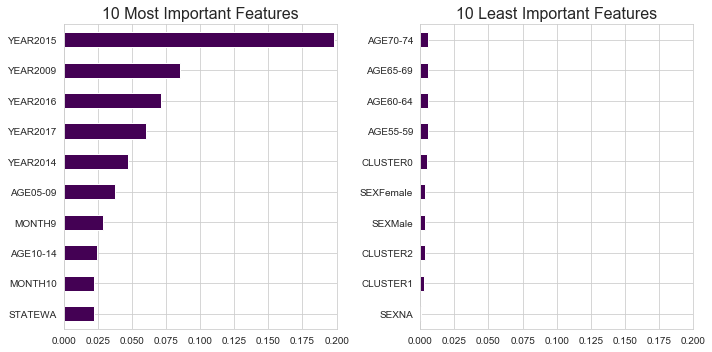

In [106]:
feat_importances = pd.Series(rfc.feature_importances_, index=XD_train.columns)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

ax1 = plt.subplot(121)
feat_importances.sort_values(ascending=True)[-10:].plot(kind='barh', xlim=(0.00, 0.20), colormap='viridis')
plt.title('10 Most Important Features', fontsize=16)

ax2 = plt.subplot(122)
feat_importances.nsmallest(10).plot(kind='barh', xlim=(0.00, 0.20), colormap='viridis')
plt.title('10 Least Important Features', fontsize=16)

plt.tight_layout()
plt.show()

We see here that the most important features for the random forest are in the YEAR categories,  AGE05-09 & 10-14, and MONTH 9 & 10 (September and October, when the Australian flu season peaks). 

Least important are all SEX columns, all CLUSTER columns, and the AGE groups from 55-74. These correspond with our GLMM and Logistic Regression models. 

## 6. Conclusion

### Key Findings

This data provided a great chance to experiment with mixed models, the standard of my unit 6 specialization: data science for the social sciences. It was also helpful to compare with some of the standard machine learning algorithms, which we were able to use to predict on new data with accuracy near 75%. Coming into this project both my mentor and I were unfamiliar with the data science tools of social sciences and this was our concept to bring them together with the more typical and state of the art models we were already familiar with. It was a project full of experimentation and failures, but sometimes that is how data science goes.

Pymer4 and Logistic Regression both had equations with coefficient values which gave them the advantage in  interpretability. Random Forest offers feature importance, though, so it wasn't as opaque as boosting models. From these reports, we learned that the SEX and CLUSTER features were of least importance/significance to all our models. The GLMM and Logistic Regression models also showed that some of the age groups were not very significant. As we noted from the visualizations, there were many more flu cases among the young, and they also increase in the oldest age group, and we must remember this data is only people who were tested and confirmed to have the flu. Thus, people who are more at risk would be more likely to go to a hospital and get checked out if they fell ill. STATE, MONTH, and YEAR features had some high variability and were the most helpful features in modeling and predicting for this data.

Unfortunately I wasn't able to predict on new data with Pymer4, but Logistic Regression and Random Forest Classification met that part of our project goal. With Logistic Regression we predicted with 74.24% accuracy, and Random Forest predicted with 75.63% accuracy on the final validation set. Prediction isn't our only goal, but it is a crucial aspect of the project, as it brings a business value to the analysis we completed in the first half. If we can predict with any accuracy above a random guess (50-50 chance), this model could be a very useful tool in a comprehensive flu prevention program by the DOH.

If I were to recommend a model to the DOH, I would use Logistic Regression, as it is easier to interpret and tune, and takes less time to run. It sits in the middle ground between the GLMMs and Random Forests, where it offers the right balance of interpretability and accuracy for our needs.

### Challenges with Packages

In trying to find a mixed model package for my analysis, my mentor and I initially explored a statsmodels method called BinomialBayesMixedGLM. While it sounds like exactly what I needed for my categorical target variable, it is under development and lacks support and examples by which to learn its application.

From there, we explored wrapper methods and discovered a promising package called Pymer4 (the name being a combination of "Python" and R packages "Lmer" and "Lme4"). It allows for both linear and non-linear mixed effects modeling. While the package is seemingly complete and has superb documentation, it also has the issue of minimal examples of real use. 

Because I am not an R user, I ran into issues with installation as well as data type requirements. Thanks to package author Eshin Jolly, I was able to resolve the installation issue after creating a ticket on the Github repo. He also added a note about my case to the installation guide for future users to avoid my pitfall.

Once I got the package running and produced my first fit, the final cherry on top was that I couldn't get the '.predict()' method to work and was unable to find a solution online. So, my mixed effects model ended up only being useful in prescriptive analysis.

The development of packages depends on demand or "hype" for that kind of approach to solving the problems of data science. Mixed models may have been much more promising in the past before more powerful models like random forests and gradient boosting became the top of the line. It seems their use is still largely within the confines of social science applications, and thus the open-source packages are rather immature. Additionally, at least one new model is in development that combines mixed models with state of the art ML models. The merf (mixed effects random forest) package is an open-source Python package that holds a lot of promise going forward, not just for social sciences. I was planning to use that as part of this project, but it turns out it only supports regression at this time.

One additional problem I faced was time constraint. This is my final capstone for my course, and paid days are running out, so I wasn't able to explore random effects as much as I wanted. At one point I let a model run for 3 days that was creating random intercepts and slopes for every month within every year and was ultimately unable to include it in this notebook. This brings me to the next point:

### Proposed Expansion of the Project
I would love to experiment more with different random effects for this model, as we really just scratched the surface of their capabilities. 

It would also be great to build the GLMM in R rather than using Pymer4, which may allow us to get an actual prediction from it. That was one of the biggest let downs of this project - only being able to use mixed models to understand our data, not predict.

On a very ambitious global scale, I think it would be really cool to build a model using data of all confirmed flu cases from all countries. Can you track the patterns of flu strains and make predictions like:
    
    What strains will be worse in which areas of the globe in year X
    If strain Y was the most common in the 2019 Australian flu season, can that be used to predict the US flu season, which follows directly after?
    
I'd be interested to add a table of historical weather data and take into account weather fluctuations on flu transmission.

This could also be scaled down some and just compare Australia with the United States, for example. I would also like to explore clustering more to see if any patterns emerged that weren't caught by my supervised learning methods.

### Wrap up

This was a very interesting investigation into mixed models for a classification problem. It's an interesting group of models and I think combining it with the state of the art machine learning algorithms could offer new possibilities in the social sciences. Obviously they are concerned more with understanding (interpretability) than prediction, but explicitly stating random effects allows for some level of control over feature importance in modeling. Additionally, many bagging and boosting models have feature importance methods, so they aren't completely useless for understanding one's data.